In [8]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib nbagg

In [2]:
num_of_sim = 100
spot_rate = 0.05
a_kappa = 0.1
b_theta = 0.05
vol = 0.01
swap_rate = 0.05
num_time_step = 40
time_step_size = 0.25
t = np.linspace(0.25, 10, 40)

In [3]:
class Swap_Mtm():
    def __init__(self, r0, kappa, theta, vol, numberOfTimeSteps, time_step_size_in_years, swap_rate, time):
        self.r0 = r0
        self.kappa = kappa
        self.theta = theta
        self.vol = vol
        self.num_of_sim = num_of_sim
        self.numberOfTimeSteps = numberOfTimeSteps
        self.dt = time_step_size_in_years
        self.t = time
        self.swap_rate = swap_rate

        self.kappa2 = kappa * kappa
        self.four_kappa = 4.0 * kappa
        self.variance = vol * vol
        self.variance_over_2 = self.variance / 2.0

    def get_A(self):
        A = np.exp(((self.get_B() - self.t) * (self.kappa2 * self.theta - self.variance_over_2)) / self.kappa2
                   - (self.variance * self.get_B() * self.get_B() / self.four_kappa))
        return A

    def get_B(self):
        B = np.array((1 - np.exp(-self.kappa * self.t)) / self.kappa)
        return B

    def get_df(self):
        return self.get_A() * np.exp(-self.get_B() * self.r0)

    def generate_path(self):
        path = []
        current = self.r0
        vol_sqr_dt = self.vol * sqrt(self.dt)

        for i in range(self.numberOfTimeSteps + 1):
            path.append(current)
            drift = self.kappa * (self.theta - current) * self.dt
            shock = vol_sqr_dt * np.random.normal(0, 1)
            current += (drift + shock)

        t = np.linspace(0, self.numberOfTimeSteps * self.dt, self.numberOfTimeSteps + 1)
        return Series(path, index=t)

    def plot_multi_paths(self, num_of_path):
        paths = DataFrame()
        for i in range(num_of_path):
            path = self.generate_path()
            paths[i] = path
        plt.plot(paths)

    def price_floating(self):
        A = self.get_A()
        B = self.get_B()
        path = self.generate_path()
        floating = 1 - A[::-1] * np.exp(-B[::-1] * path.iloc[:-1])
        return floating

    def price_fixed(self):
        path = self.generate_path()
        df = DataFrame(np.zeros((self.numberOfTimeSteps, self.numberOfTimeSteps)))
        A = self.get_A()
        B = self.get_B()
        for i in range(self.numberOfTimeSteps):
            df.ix[i, :(self.numberOfTimeSteps - 1 - i)] = A[:(40-i)] * np.exp(-B[:(40-i)] * path.iloc[i])
        cumsum = df.cumsum(axis=1).ix[:, (self.numberOfTimeSteps - 1)]
        return self.swap_rate * cumsum * self.dt

    def generate_multi_MtM(self, num_of_sim):
        sim = DataFrame()
        for i in range(num_of_sim):
            MtM = self.price_fixed() - self.price_floating().reset_index(drop=True)
            sim[i] = MtM
        sim = sim.append(DataFrame(np.zeros((1,num_of_sim))), ignore_index=True)
        return sim

    def plot_PFE_EE(self, quantile, num_of_sim):
        simulation = self.generate_multi_MtM(num_of_sim)
        PFE = simulation.quantile(quantile, axis=1)
        EE = np.sum(simulation[simulation>0], axis=1)/num_of_sim
        plt.plot(PFE)
        plt.plot(EE)

    def plot_single_path(self):
        spot = self.generate_path()
        plt.plot(spot)

    def plot_fv(self):
        fv = self.generate_multi_MtM(1)
        plt.plot(fv)

In [4]:
swap = Swap_Mtm(spot_rate, a_kappa, b_theta, vol, num_time_step, time_step_size, swap_rate, t)

<IPython.core.display.Javascript object>


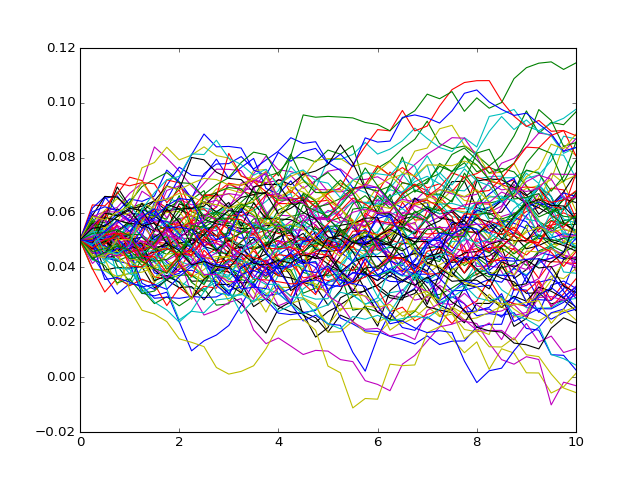

In [15]:
# generate 100 paths of interest rate
swap.plot_multi_paths(100)

<IPython.core.display.Javascript object>


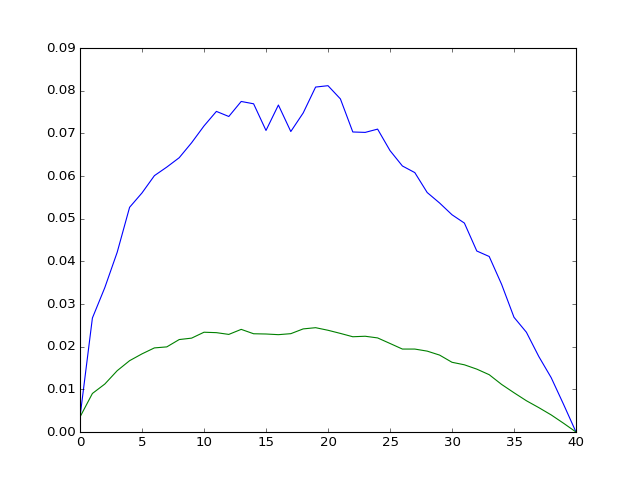

In [11]:
# 90th percentile PFE & EE of 250 paths
swap.plot_PFE_EE(0.9, 250)

<IPython.core.display.Javascript object>


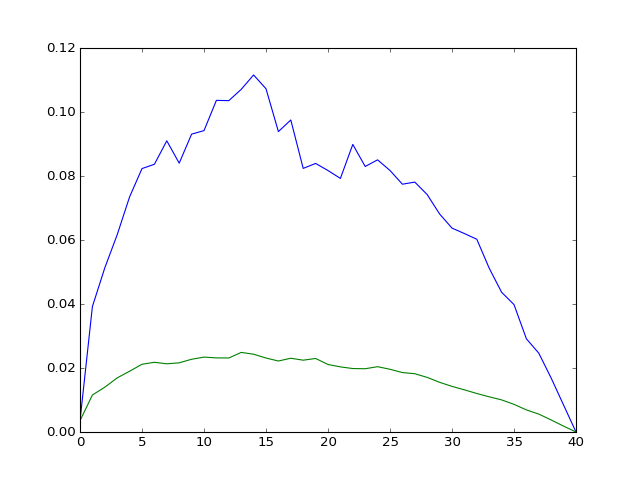

In [13]:
# 95th percentile of 250 simulations
swap.plot_PFE_EE(0.95, 250)

<IPython.core.display.Javascript object>


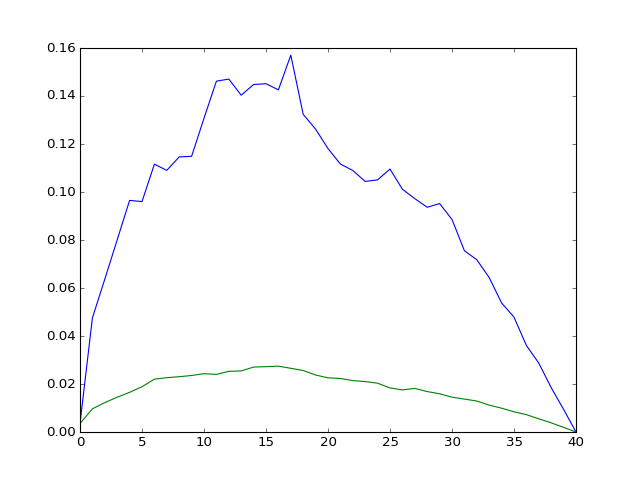

In [14]:
# 99th percentile
swap.plot_PFE_EE(0.99, 250)

<IPython.core.display.Javascript object>


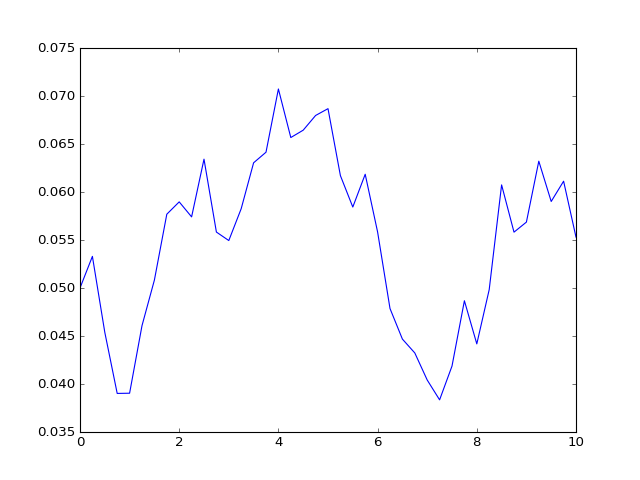

In [18]:
# plot single path of spot interest
swap.plot_single_path()

<IPython.core.display.Javascript object>


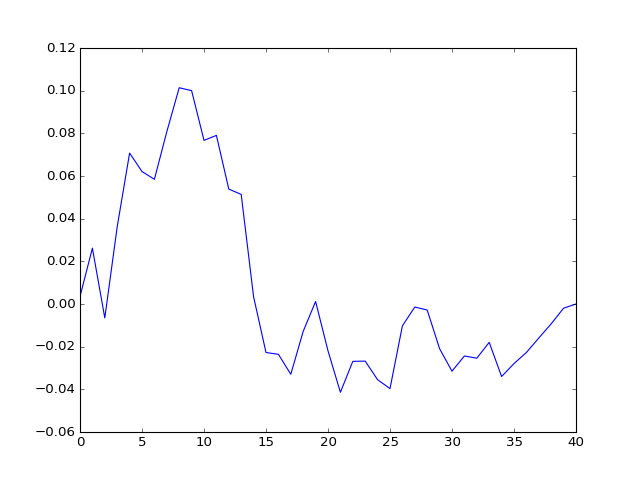

In [21]:
# plot single path of FV of the swap
swap.plot_fv()